In [55]:
import numpy as np
import pandas as pd
import os

# Caricamento dei word embeddings

In [56]:
embeddings_dim = 128
embeddings_path = f'..\data/word_embeddings/itwac{embeddings_dim}.txt'

In [57]:
def load_word_embeddings(src_path):
    '''crea un dizionario contenente gli embedding di parole presente nel file src_path'''
    embeddings = dict() # dizionario che conterrà gli embedding
    for line in open(embeddings_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [58]:
embeddings = load_word_embeddings(embeddings_path)

In [59]:
len(embeddings)

1247492

# Caricamento dataset

In [60]:
conllu_dir = 'FB_profilingUD_annotazione_linguistica'

In [61]:
train_files = []
test_files = []

for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    if 'train' in file_name:
        train_files.append(file_path)
    elif 'test' in file_name:
        test_files.append(file_path)

print('Documenti training set:', len(train_files))
print('Documenti test set:', len(test_files))

Documenti training set: 3000
Documenti test set: 1000


### Normalizzazione delle parole

In [62]:
import re

def get_digits(text):
    try:
      val = int(text) # converte la stringa in intero
    except:
      text = re.sub('\d', '@Dg', text) # sostituisce a ogni cifra in text la stringa '@Dd'
      return text
    if val >= 0 and val < 2100: # se è un numero tra 0 e 2100
      return str(val) # viene lasciato uguale
    else:
      return "DIGLEN_" + str(len(str(val))) # viene indicato il numero di cifre che compongono quel numero

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper(): # se la parola inizia con la lettera maiuscola
      word = word.capitalize() # viene trasformata tutta in maiuscolo
    else:
      word = word.lower() # tutta in minuscolo
    return word

In [63]:
def get_tokens_from_file(src_path):
    doc_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit(): # cioè non siamo nell'indentazione
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                # print('Ho trovato un - ')
                skip_ids = splitted_line[0].split('-')
                # print('Indici da saltare', skip_ids)
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1]) # normalizza la parola
                pos = splitted_line[3]
                token = {'word': word, 'pos': pos} # crea il dizionario del token
                # print(f'Preso token {word}')
                doc_tokens.append(token) # inserisce il dizionario alla lista dei token del documento
            else: # se non c'è il trattito nell'indice
                if lines_to_skip == 0:
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {'word': word, 'pos': pos}
                    # print(f'Preso token {word}')
                    doc_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    doc_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return doc_tokens

In [64]:
train_dataset = []
y_train = []

for path in train_files:
    post_tokens = get_tokens_from_file(path)
    train_dataset.append(post_tokens)
    y_train.append(int(path.split('-')[2]))

In [65]:
train_dataset[1]

[{'word': 'Ma', 'pos': 'CCONJ'},
 {'word': 'e', 'pos': 'CCONJ'},
 {'word': 'vero', 'pos': 'ADJ'},
 {'word': 'che', 'pos': 'SCONJ'},
 {'word': 'avete', 'pos': 'AUX'},
 {'word': 'approvato', 'pos': 'VERB'},
 {'word': 'una', 'pos': 'DET'},
 {'word': 'legge', 'pos': 'NOUN'},
 {'word': 'per', 'pos': 'ADP'},
 {'word': 'i', 'pos': 'DET'},
 {'word': 'parlamentari', 'pos': 'NOUN'},
 {'word': 'in', 'pos': 'ADP'},
 {'word': 'crisi', 'pos': 'NOUN'},
 {'word': 'a', 'pos': 'ADP'},
 {'word': 'fine', 'pos': 'NOUN'},
 {'word': 'legislatura', 'pos': 'ADJ'},
 {'word': '?', 'pos': 'PUNCT'},
 {'word': 'Poverini', 'pos': 'NOUN'},
 {'word': 'dopo', 'pos': 'ADP'},
 {'word': 'tutte', 'pos': 'DET'},
 {'word': 'le', 'pos': 'DET'},
 {'word': 'miniere', 'pos': 'NOUN'},
 {'word': 'scavate', 'pos': 'ADJ'},
 {'word': 'ci', 'pos': 'PRON'},
 {'word': 'vuole', 'pos': 'VERB'},
 {'word': 'proprio', 'pos': 'ADV'},
 {'word': '!!!', 'pos': 'PUNCT'},
 {'word': '!!!', 'pos': 'PUNCT'}]

In [66]:
len(y_train)

3000

# Estrazione features

Definisco alcune funzioni che permettono di aggregare, in modi diversi, i word embedding delle parole contenute in ogni post. Nello specifico, è sufficiente concentrarsi soltanto su nomi, aggettivi e verbi, dato il task da svolgere.

In [67]:
def compute_embeddings_mean(embeddings):
    sum_array = np.sum(embeddings, axis=0)
    mean_array = np.divide(sum_array, len(embeddings))
    return mean_array

In [68]:
def compute_filtered_embeddings_mean(post_tokens):
    '''Calcola la media dei word embeddings solo di aggettivi, nomi, verbi e avverbi.'''
    post_embeddings = []
    
    for token in post_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB', 'ADV']:
            post_embeddings.append(embeddings[word])
    
    if len(post_embeddings) == 0:
        post_embeddings = [np.zeros(embeddings_dim)]
    
    post_embeddings = compute_embeddings_mean(post_embeddings)
    return post_embeddings

In [69]:
def compute_filtered_embeddings_sep_means(post_tokens):
    '''Calcola separamente le medie degli embedding di aggettivi, nomi, verbi e avverbi, e concatena i 4 vettori ottenuti.'''
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    adv_embeddings = []
    
    for token in post_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['ADV']:
            adv_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        adj_embeddings = [np.zeros(embeddings_dim)]
    if len(noun_embeddings) == 0:
        noun_embeddings = [np.zeros(embeddings_dim)]
    if len(verb_embeddings) == 0:
        verb_embeddings = [np.zeros(embeddings_dim)]
    if len(adv_embeddings) == 0:
        adv_embeddings = [np.zeros(embeddings_dim)]
    
    adj_embeddings = np.mean(adj_embeddings, axis=0)
    noun_embeddings = np.mean(noun_embeddings, axis=0)
    verb_embeddings = np.mean(verb_embeddings, axis=0)
    adv_embeddings = np.mean(adv_embeddings, axis=0)
    
    post_embeddings = np.concatenate([adj_embeddings, noun_embeddings, verb_embeddings, adv_embeddings], axis=None)
    return post_embeddings

In [70]:
def compute_filtered_embeddings_sum(post_tokens):
    '''Calcola la somma dei word embeddings solo di aggettivi, nomi, verbi e avverbi.'''
    post_embeddings = []
    
    for token in post_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB', 'ADV']:
            post_embeddings.append(embeddings[word])
    
    if len(post_embeddings) == 0:
        post_embeddings = [np.zeros(embeddings_dim)]
    
    post_embeddings = np.sum(post_embeddings, axis=0)
    return post_embeddings

In [71]:
def compute_filtered_embeddings_sep_sums(post_tokens):
    '''Calcola separamente la somma degli embedding di aggettivi, nomi, verbi e avverbi, e concatena i 4 vettori ottenuti.'''
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    adv_embeddings = []
    
    for token in post_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['ADV']:
            adv_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        adj_embeddings = [np.zeros(embeddings_dim)]
    if len(noun_embeddings) == 0:
        noun_embeddings = [np.zeros(embeddings_dim)]
    if len(verb_embeddings) == 0:
        verb_embeddings = [np.zeros(embeddings_dim)]
    if len(adv_embeddings) == 0:
        adv_embeddings = [np.zeros(embeddings_dim)]
    
    adj_embeddings = np.sum(adj_embeddings, axis=0)
    noun_embeddings = np.sum(noun_embeddings, axis=0)
    verb_embeddings = np.sum(verb_embeddings, axis=0)
    adv_embeddings = np.sum(adv_embeddings, axis=0)
    
    post_embeddings = np.concatenate([adj_embeddings, noun_embeddings, verb_embeddings, adv_embeddings], axis=None)
    return post_embeddings

In [72]:
def compute_filtered_embeddings_product(post_tokens):
    '''Calcola il prodotto dei word embeddings solo di aggettivi, nomi, verbi e avverbi.'''
    post_embeddings = []
    
    for token in post_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ', 'NOUN', 'VERB', 'ADV']:
            post_embeddings.append(embeddings[word])
    
    if len(post_embeddings) == 0:
        post_embeddings = [np.zeros(embeddings_dim)]
    
    post_embeddings = np.prod(post_embeddings, axis=0)
    return post_embeddings

In [73]:
def compute_filtered_embeddings_sep_products(post_tokens):
    '''Calcola separamente il prodotto degli embedding di aggettivi, nomi, verbi e avverbi, e concatena i 4 vettori ottenuti.'''
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    adv_embeddings = []
    
    for token in post_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['ADV']:
            adv_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        adj_embeddings = [np.zeros(embeddings_dim)]
    if len(noun_embeddings) == 0:
        noun_embeddings = [np.zeros(embeddings_dim)]
    if len(verb_embeddings) == 0:
        verb_embeddings = [np.zeros(embeddings_dim)]
    if len(adv_embeddings) == 0:
        adv_embeddings = [np.zeros(embeddings_dim)]
    
    adj_embeddings = np.prod(adj_embeddings, axis=0)
    noun_embeddings = np.prod(noun_embeddings, axis=0)
    verb_embeddings = np.prod(verb_embeddings, axis=0)
    adv_embeddings = np.prod(adv_embeddings, axis=0)
    
    post_embeddings = np.concatenate([adj_embeddings, noun_embeddings, verb_embeddings, adv_embeddings], axis=None)
    return post_embeddings

### Creazione del training set  

Ogni post è rappresentato dall'aggregazione degli embedding dei token che lo compongono. Definisco alcune funzioni che estraggono soltanto il tipo di aggregazione che mi interessa (media, somma, prodotto o concatenazione di medie/somme/prodotti).

In [74]:
def extract_means(dataset):
    dataset_features = []
    for post_tokens in dataset:
        post_embeddings = compute_filtered_embeddings_mean(post_tokens)
        dataset_features.append(post_embeddings)
    return dataset_features

In [75]:
def extract_sep_means(dataset):
    dataset_features = []
    for post_tokens in dataset:
        post_embeddings = compute_filtered_embeddings_sep_means(post_tokens)
        dataset_features.append(post_embeddings)
    return dataset_features

In [76]:
def extract_sums(dataset):
    dataset_features = []
    for post_tokens in dataset:
        post_embeddings = compute_filtered_embeddings_sum(post_tokens)
        dataset_features.append(post_embeddings)
    return dataset_features

In [77]:
def extract_sep_sums(dataset):
    dataset_features = []
    for post_tokens in dataset:
        post_embeddings = compute_filtered_embeddings_sep_sums(post_tokens)
        dataset_features.append(post_embeddings)
    return dataset_features

In [78]:
def extract_products(dataset):
    dataset_features = []
    for post_tokens in dataset:
        post_embeddings = compute_filtered_embeddings_product(post_tokens)
        dataset_features.append(post_embeddings)
    return dataset_features

In [79]:
def extract_sep_products(dataset):
    dataset_features = []
    for post_tokens in dataset:
        post_embeddings = compute_filtered_embeddings_sep_products(post_tokens)
        dataset_features.append(post_embeddings)
    return dataset_features

In [80]:
train_means = extract_means(train_dataset)
train_sep_means = extract_sep_means(train_dataset)
train_sums = extract_sums(train_dataset)
train_sep_sums = extract_sep_sums(train_dataset)
train_products = extract_products(train_dataset)
train_sep_products = extract_sep_products(train_dataset)

# Normalizzazione delle features dei diversi dataset

In [81]:
from sklearn.preprocessing import MinMaxScaler

mean_scaler = MinMaxScaler()
X_train_means = mean_scaler.fit_transform(train_means)
X_train_means.shape
# X_train = np.stack(train_features, axis=0)

(3000, 128)

In [82]:
sep_means_scaler = MinMaxScaler()
X_train_sep_means = sep_means_scaler.fit_transform(train_sep_means)
X_train_sep_means.shape

(3000, 512)

In [83]:
sum_scaler = MinMaxScaler()
X_train_sums = sum_scaler.fit_transform(train_sums)
X_train_sums.shape

(3000, 128)

In [84]:
sep_sums_scaler = MinMaxScaler()
X_train_sep_sums = sep_sums_scaler.fit_transform(train_sep_sums)
X_train_sep_sums.shape

(3000, 512)

In [85]:
prod_scaler = MinMaxScaler()
X_train_products = prod_scaler.fit_transform(train_products)
X_train_products.shape

(3000, 128)

In [86]:
sep_prod_scaler = MinMaxScaler()
X_train_sep_products = sep_prod_scaler.fit_transform(train_sep_products)
X_train_sep_products.shape

(3000, 512)

# Classificazione

In [87]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, KFold, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

## Model selection

In [88]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

### Scelta di C nel modello addestrato sulle medie degli embeddings

In [89]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_means, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_means, y_train)
    scores = cross_validate(svc, X_train_means, y_train, scoring='accuracy', cv=splitter) # effettuiamo la Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.543000,0.539667,0.008844
1,0.0010,0.705333,0.692333,0.013646
2,0.0100,0.748000,0.733667,0.012884
3,0.1000,0.777333,0.749667,0.015825
4,1.0000,0.780000,0.751000,0.019020


### Scelta di C nel modello addestrato sulla concatenazione di medie

In [90]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_sep_means, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_sep_means, y_train)
    scores = cross_validate(svc, X_train_sep_means, y_train, scoring='accuracy', cv=splitter) # Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.636333,0.612000,0.008844
1,0.0010,0.737667,0.716333,0.006446
2,0.0100,0.789333,0.754333,0.011479
3,0.1000,0.825333,0.755000,0.012561
4,1.0000,0.838000,0.739667,0.012401


### Scelta di C nel modello addestrato sulle somme

In [91]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_sums, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_sums, y_train)
    scores = cross_validate(svc, X_train_sums, y_train, scoring='accuracy', cv=splitter) # Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.567667,0.558333,0.009006
1,0.0010,0.650333,0.642000,0.011025
2,0.0100,0.726333,0.713333,0.013081
3,0.1000,0.786333,0.768667,0.016580
4,1.0000,0.798333,0.774333,0.017689


### Scelta di C nel modello addestrato sulla concatenazione di somme

In [92]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_sep_sums, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_sep_sums, y_train)
    scores = cross_validate(svc, X_train_sep_sums, y_train, scoring='accuracy', cv=splitter) # Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.590667,0.579333,0.008340
1,0.0010,0.678000,0.663667,0.008524
2,0.0100,0.763333,0.739333,0.012229
3,0.1000,0.821667,0.776000,0.014553
4,1.0000,0.850000,0.771667,0.016228


### Scelta di C nel modello addestrato sui prodotti

In [93]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_products, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_products, y_train)
    scores = cross_validate(svc, X_train_products, y_train, scoring='accuracy', cv=splitter) # Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.539333,0.539333,0.008273
1,0.0010,0.561667,0.557333,0.008069
2,0.0100,0.567333,0.562333,0.008273
3,0.1000,0.578000,0.566000,0.012320
4,1.0000,0.584000,0.559333,0.013848


### Scelta di C nel modello addestrato sulla concatenazione di prodotti

In [94]:
df = pd.DataFrame(np.array([0.0001, 0.001, 0.01, 0.1, 1]), columns = ['C'])
for i, c in enumerate(df['C']): # proviamo diversi valori dell'iperparametro regolarizzatore C
    svc = LinearSVC(dual=False, C=c)
    svc.fit(X_train_sep_products, y_train) # addestriamo il modello con il valore di C da valutare
    df.loc[i, 'training_accuracy'] = svc.score(X_train_sep_products, y_train)
    scores = cross_validate(svc, X_train_sep_products, y_train, scoring='accuracy', cv=splitter) # Cross Validation
    df.loc[i, 'val_accuracy'] = scores['test_score'].mean()
    df.loc[i, 'val_accuracy_std'] = scores['test_score'].std()
df

,C,training_accuracy,val_accuracy,val_accuracy_std
0,0.0001,0.541000,0.540000,0.008433
1,0.0010,0.639333,0.610333,0.015398
2,0.0100,0.685667,0.643000,0.018661
3,0.1000,0.720000,0.640667,0.007272
4,1.0000,0.745667,0.641333,0.005715


L'accuracy in validation migliore viene ottenuta dal SVC addestrato sulla concatenazione delle somme degli embeddings delle parole piene. Testiamo dunque questo modello anche sul test set.

## Valutazione sul test set

### Preparazione del test set

In [95]:
test_dataset = []
y_test = []
for file_path in test_files:
    doc_sentences = get_tokens_from_file(file_path)
    test_dataset.append(doc_sentences)
    y_test.append(int(file_path.split('-')[2]))

test_features = extract_sep_sums(test_dataset)

In [96]:
X_test = sep_sums_scaler.transform(test_features)

In [97]:
len(y_test)

1000

In [98]:
best_svc_sep_sums = LinearSVC(dual=False, C=0.1)
# creiamo il modello con il valore di C migliore per la concatenazione di medie
best_svc_sep_sums.fit(X_train_sep_sums, y_train)

LinearSVC(C=0.1, dual=False)

In [99]:
y_pred = best_svc_sep_sums.predict(X_test)
print(classification_report(y_test, y_pred,  zero_division=0))

              precision    recall  f1-score   support

           0       0.56      0.74      0.64       323
           1       0.85      0.72      0.78       677

    accuracy                           0.73      1000
   macro avg       0.70      0.73      0.71      1000
weighted avg       0.76      0.73      0.73      1000



In [100]:
accuracy_score(y_pred=y_pred, y_true=y_test)

0.726

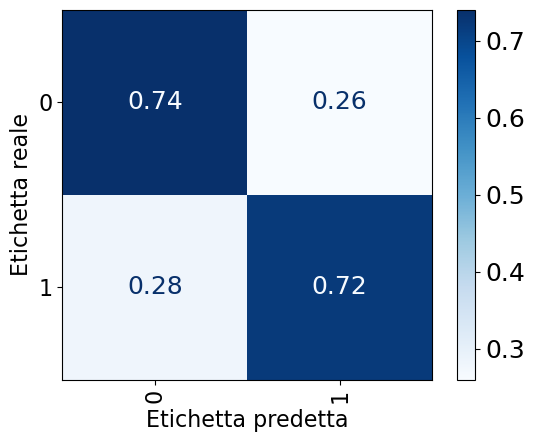

In [102]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig('conf_matrix_SVC_embeddings.pdf', dpi=300, bbox_inches='tight')
plt.show()